In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df[40:50]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
40,49,47,Female,49_left.jpg,49_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",49_right.jpg
41,50,59,Female,50_left.jpg,50_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy，laser spot,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",50_right.jpg
42,51,60,Male,51_left.jpg,51_right.jpg,normal fundus,epiretinal membrane over the macula,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",51_right.jpg
43,52,67,Male,52_left.jpg,52_right.jpg,normal fundus,myelinated nerve fibers,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",52_right.jpg
44,53,65,Female,53_left.jpg,53_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",53_right.jpg
45,54,66,Female,54_left.jpg,54_right.jpg,normal fundus,moderate non proliferative retinopathy，patholo...,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",54_right.jpg
46,55,62,Male,55_left.jpg,55_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",55_right.jpg
47,56,63,Female,56_left.jpg,56_right.jpg,normal fundus,epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",56_right.jpg
48,58,74,Male,58_left.jpg,58_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",58_right.jpg
49,60,54,Female,60_left.jpg,60_right.jpg,normal fundus,epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",60_right.jpg


In [3]:
def has_dry_age_related_macular_degeneration(text):
    if "dry age-related macular degeneration" in text:
        return 1
    elif "wet age-related macular degeneration" in text:
        return 1
    elif "refractive media opacity" in text:
        return 1
    elif "glaucoma" in text:
        return 1
    else:
        return 0

In [4]:
df["left_dry_age_related_macular_degeneration"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_dry_age_related_macular_degeneration(x))
df["right_dry_age_related_macular_degeneration"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_dry_age_related_macular_degeneration(x))


In [5]:
left_dry_age_related_macular_degeneration = df.loc[(df.D == 1) & (df.left_dry_age_related_macular_degeneration == 1)]["Left-Fundus"].values
right_dry_age_related_macular_degeneration = df.loc[(df.D == 1) & (df.right_dry_age_related_macular_degeneration == 1)]["Right-Fundus"].values


In [6]:
left_dry_age_related_macular_degeneration[:15], right_dry_age_related_macular_degeneration[:15]
len(right_dry_age_related_macular_degeneration)

64

In [7]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [8]:
amd = np.concatenate((left_dry_age_related_macular_degeneration ,right_dry_age_related_macular_degeneration ),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [9]:
print(len(amd),len(normal))

126 500


In [10]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [11]:
dataset = create_dataset(amd,1)

100%|██████████| 126/126 [00:01<00:00, 82.88it/s]


In [12]:
len(dataset)

126

In [13]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:07<00:00, 64.50it/s]


In [14]:
len(dataset)

626

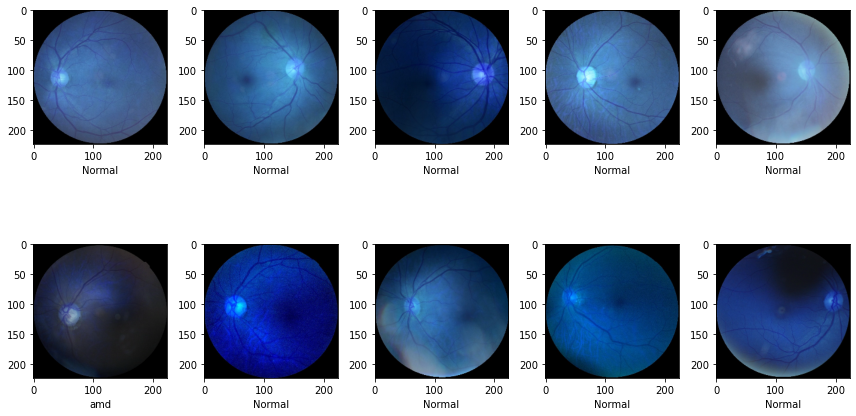

In [15]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "amd"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [16]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [18]:
count_ones = np.sum(y_test == 1)
count_ones

25

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19

# Set the path to your local weights file
weights_path = '/kaggle/input/vgg19/tensorflow2/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load VGG19 model with local weights
vgg = VGG19(weights=weights_path, include_top=False, input_shape=(image_size, image_size, 3))


In [20]:
for layer in vgg.layers:
    layer.trainable = False

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [25]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
16/16 [==============================] - 3s 171ms/step - loss: 1.9971 - accuracy: 0.7560 - val_loss: 3.0566 - val_accuracy: 0.8175
Epoch 2/10
16/16 [==============================] - 1s 85ms/step - loss: 1.2211 - accuracy: 0.8580 - val_loss: 1.4243 - val_accuracy: 0.8730
Epoch 3/10
16/16 [==============================] - 1s 85ms/step - loss: 0.5422 - accuracy: 0.9320 - val_loss: 1.1359 - val_accuracy: 0.9127
Epoch 4/10
16/16 [==============================] - 1s 84ms/step - loss: 0.1040 - accuracy: 0.9780 - val_loss: 1.4019 - val_accuracy: 0.8968
Epoch 5/10
16/16 [==============================] - 1s 84ms/step - loss: 0.0640 - accuracy: 0.9880 - val_loss: 0.9513 - val_accuracy: 0.9206
Epoch 6/10
16/16 [==============================] - 1s 84ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.8913 - val_accuracy: 0.8968
Epoch 7/10
16/16 [==============================] - 1s 84ms/step - loss: 7.0596e-04 - accuracy: 1.0000 - val_loss: 0.8753 - val_accuracy: 0.9127
Epoch 8/

In [26]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 0s 52ms/step - loss: 0.8910 - accuracy: 0.9127
loss: 0.8910068869590759
Accuracy: 0.9126983880996704


In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_test)

In [28]:
model.save("AgeMasclarDegeneration.h5")

In [29]:
accuracy_score(y_test,y_pred)

0.9126984126984127

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       101
           1       0.77      0.80      0.78        25

    accuracy                           0.91       126
   macro avg       0.86      0.87      0.86       126
weighted avg       0.91      0.91      0.91       126



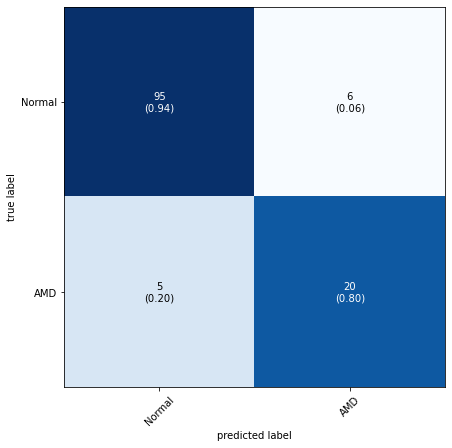

In [31]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","AMD"],
                      show_normed = True);

ValueError: x and y must have same first dimension, but have shapes (15,) and (10,)

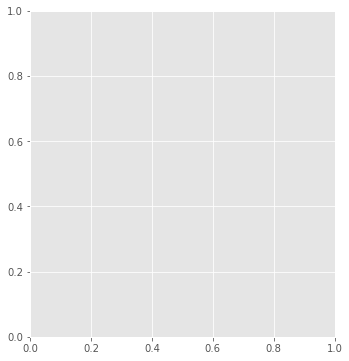

In [32]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "AMD"      
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "AMD"   
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [ ]:
# Load and preprocess the new image
new_image = cv2.imread("/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/1085_right.jpg", cv2.IMREAD_COLOR)
new_image = cv2.resize(new_image, (image_size, image_size))
new_image = np.array(new_image).reshape(1, image_size, image_size, 3)

In [ ]:
prediction = model.predict_classes(new_image)
prediction